# **Python for Finance -- Session 3 -- Solutions**
---
<img src="http://www.doc.ic.ac.uk/~afd/images/logo_imperial_college_london.png" align = "left" width=200>
 <br><br><br><br>
 
- Copyright (c) Antoine Jacquier, 2021. All rights reserved

- Author: Antoine Jacquier <a.jacquier@imperial.ac.uk>

- Platform: Tested on Windows 10 with Python 3.7

## Data Import and visualisation

### Import and histogram

C:\Users\ajacquie\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ajacquie\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


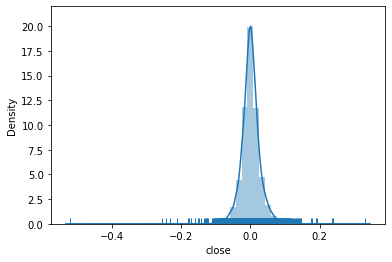

In [1]:
import seaborn as sns
import yahoo_fin.stock_info as si
aapl = si.get_data("aapl")["close"].pct_change()
sns.distplot(aapl, kde=True, rug=True);

### Get all history from S&P

In [2]:
import yahoo_fin.stock_info as si

listTickers = si.tickers_sp500() # list of S&P 500 tickers
 
spAll = {}
tickersNotWorking = []
for ticker in listTickers:
    try:
        temp =  si.get_data(ticker, start_date = "01/01/2017", end_date = "01/05/2017")
        spAll[ticker] = temp
    except:
        tickersNotWorking.append(ticker)

In [3]:
### spAll contains everything, as a dictionary.
## To call any, for example:
spAll["AMZN"].head()

,open,high,low,close,adjclose,volume,ticker
2017-01-03,757.919983,758.760010,747.700012,753.669983,753.669983,3521100,AMZN
2017-01-04,758.390015,759.679993,754.200012,757.179993,757.179993,2510500,AMZN


## Webscraping

The first method was working, but the website www.coinmarketcap.com has changed their setup and the procedure does not work anymore unfortunately.
I added a new method (using an available package).

In [4]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as plticker

In [5]:
def importHistData(crypto, startDate, endDate):
    sDate, eDate = startDate.strftime("%Y%m%d"), endDate.strftime("%Y%m%d")
    url = "https://coinmarketcap.com/currencies/" + crypto + "/historical-data/?start=" + sDate + "&end=" + eDate
    content = requests.get(url).content
    soup = BeautifulSoup(content,'html.parser')
    table = soup.find_all(class_="cmc-tab-historical-data")[0]
    data = [[td.text.strip() for td in tr.findChildren('td')] for tr in table.findChildren('tr')]
    dates = [datetime.strptime(d[0], '%b %d, %Y') for d in data[3:]]
    closeValues = [float(d[3].replace(',','')) for d in data[3:]]

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(dates, closeValues, 'b')
    loc = plticker.MultipleLocator(base=60)
    ax.xaxis.set_major_locator(loc)
    plt.title("Evolution of %s"  %crypto)
    plt.show()

In [7]:
listCryptos = ["bitcoin", "ethereum-classic"]#, "litecoin", "tezos", "kyber-network", "chainlink", "0x"]
crypto = listCryptos[1]
startDate = datetime(2021, 1, 1)
endDate = datetime.today()
importHistData(crypto, startDate, endDate)

IndexError: list index out of range

In [9]:
!pip install cryptocmd

In [10]:
from cryptocmd import CmcScraper

scraper = CmcScraper("XRP")
#headers, data = scraper.get_data()
#xrp_json_data = scraper.get_data("json")

## export the data as csv file, you can also pass optional `name` parameter
#scraper.export("csv", name="xrp_all_time")

# Pandas dataFrame for the same data
df = scraper.get_dataframe()

df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2021-11-05,1.201917,1.202404,1.141375,1.161533,3.572444e+09,5.468691e+10
1,2021-11-04,1.210519,1.253728,1.166933,1.202003,5.210116e+09,5.659230e+10
2,2021-11-03,1.135938,1.233025,1.126961,1.208796,6.526804e+09,5.691214e+10
3,2021-11-02,1.092577,1.145094,1.086117,1.136196,3.609678e+09,5.349401e+10
4,2021-11-01,1.113153,1.131215,1.072657,1.092867,3.655824e+09,5.138142e+10


## Application to option pricing

### Import the `bokeh` libraries

In [11]:
import bokeh.plotting
import bokeh.io
import bokeh.plotting.figure as bk_figure
from bokeh.io import curdoc, show
from bokeh.layouts import row, widgetbox
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Slider, TextInput
from bokeh.io import output_notebook # enables plot interface in J notebook
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
import numpy as np
bokeh.io.output_notebook()

Loading BokehJS ...

### Define the Black-Scholes Call price function

In [14]:
from scipy.stats import norm

def bsCall(s0, K, sigma, t, T):
    '''
    #Inputs:
    S0: initial stock price
    K: strike
    sigma: instantaneous volatility
    T: time to maturity
    #Output:
    Black-Scholes Call price
    '''
    tau = T - t
    sigmtau = sigma*np.sqrt(tau)
    k = np.log(K/s0)
    dp = -k / sigmtau + 0.5*sigmtau
    dm = dp - sigmtau
    return s0*(norm.cdf(dp) - np.exp(k)*norm.cdf(dm))

In [15]:
s0, K, sigma, t, T = 100., 100., 0.2, 0., 1.
print("Black-Scholes Call option price:", bsCall(s0,K,sigma,t,T))

Black-Scholes Call option price: 7.965567455405798


In [16]:
# Set up data
n = 200
KK = np.linspace(0.1*S0, 3.*S0, n)
cc = np.array([BSCall(S0,K,sigma,t,T) for K in KK])
source = ColumnDataSource(data=dict(x=KK, y=cc))

# Set up plot
plot = bk_figure(plot_height=400, plot_width=400, title="Black-Scholes Call Price function",
              tools="crosshair,pan,reset,save,wheel_zoom",
              x_range=[np.min(KK), np.max(KK)], y_range=[np.min(cc), np.max(cc)])

plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

vol = Slider(title="Volatility", value=sigma, start=0.01, end=1., step=0.02)
maturity = Slider(title="Maturity", value=T, start=0.1, end=5., step=0.1)

def update_data(attrname, old, new):
    # Get the current slider values
    mat = maturity.value
    v = vol.value
    # Generate the new curve
    newcc = np.array([bsCall(S0,K,v,0.,mat) for K in KK])

    source.data = dict(x=KK, y=newcc)

for w in [vol, maturity]:
    w.on_change('value', update_data)

# Set up layouts and add to document
inputs = widgetbox(vol, maturity)
layout = row(plot, widgetbox(vol, maturity))

def modify_doc(doc):
    doc.add_root(row(layout, width=800))
    doc.title = "Sliders"

handler = FunctionHandler(modify_doc)
show(Application(handler))